In [2]:
import os
import pandas as pd
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [3]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [4]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [5]:
from blocksnet import CityModel

city_model = CityModel(
  blocks=aggregated_blocks, 
  accessibility_matrix=accessibility_matrix, 
  services=services
)

/Users/mvin/Desktop/masterplanning/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from blocksnet import ProvisionModel

services_prov = {}

for service_type in city_model.get_service_types():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov[service_type] = provision.run(overflow=True)
    print(service_type)

schools
kindergartens
recreational_areas
hospitals
pharmacies
policlinics


In [8]:
graph = city_model.services_graph

In [9]:
graph.nodes[257]

{'population': 164.0,
 'is_living': True,
 'id': 257,
 'is_schools_service': 0,
 'provision_schools': 0,
 'id_schools': 0,
 'schools_capacity': 0,
 'population_prov_schools': 0,
 'population_unprov_schools': 164.0,
 'is_kindergartens_service': 0,
 'provision_kindergartens': 0,
 'id_kindergartens': 0,
 'kindergartens_capacity': 0,
 'population_prov_kindergartens': 0,
 'population_unprov_kindergartens': 164.0,
 'is_recreational_areas_service': 1,
 'provision_recreational_areas': 0,
 'id_recreational_areas': 0,
 'recreational_areas_capacity': 8930,
 'population_prov_recreational_areas': 0,
 'population_unprov_recreational_areas': 164.0,
 'is_hospitals_service': 0,
 'provision_hospitals': 0,
 'id_hospitals': 0,
 'hospitals_capacity': 0,
 'population_prov_hospitals': 0,
 'population_unprov_hospitals': 164.0,
 'is_pharmacies_service': 0,
 'provision_pharmacies': 0,
 'id_pharmacies': 0,
 'pharmacies_capacity': 0,
 'population_prov_pharmacies': 0,
 'population_unprov_pharmacies': 164.0,
 'is_p

In [10]:
import torch
from torch_geometric.data import Data
import networkx as nx

In [11]:
# Преобразуйте граф в формат набора данных PyTorch GNN
edges = list(graph.edges())

x = torch.tensor([[graph.nodes[node][feature] for feature in graph.nodes[node]] for node in graph.nodes()])
edge_index = torch.tensor([[node1, node2] for node1, node2 in edges], dtype=torch.long).t().contiguous()
data = Data(x=x, edge_index=edge_index)

# Присвойте каждому элементу x класса 1 или 0
y = torch.randint(10, (data.num_nodes,), dtype=torch.float)  # Генерируйте случайные значения классов (1 или 0)
data.y = y

# Создайте тренировочную маску для 10 случайных узлов
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:200] = True
data.train_mask = train_mask

test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[:100] = True
data.test_mask = test_mask

print(data)

ValueError: expected sequence of length 39 at dim 1 (got 27)

In [17]:
# Определите num_features на основе количества признаков на узел
num_features = 39

# Преобразуйте граф в формат набора данных PyTorch GNN
edges = list(graph.edges())
num_nodes = len(graph.nodes())
x = torch.zeros((num_nodes, num_features), dtype=torch.float)  # num_features - количество признаков на узел

# Заполните x данными узлов
for node in graph.nodes():
    node_data = [graph.nodes[node]['population'], graph.nodes[node]['is_living']]
    x[node] = torch.tensor(node_data, dtype=torch.float)

edge_index = torch.tensor([[node1, node2] for node1, node2 in edges], dtype=torch.long).t().contiguous()
data = Data(x=x, edge_index=edge_index)

# Присвойте каждому элементу x класс 1 или 0
y = torch.randint(10, (data.num_nodes,), dtype=torch.float)  # Генерируйте случайные значения классов (1 или 0)
data.y = y

# Создайте тренировочную маску для 10 случайных узлов
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:200] = True
data.train_mask = train_mask

test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[:100] = True
data.test_mask = test_mask

print(data)


TypeError: must be real number, not dict

In [ ]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of nodes: 1355
Number of edges: 365560
Average node degree: 269.79
Number of training nodes: 200
Training node label rate: 0.15
Has isolated nodes: False
Has self-loops: False
Is undirected: False


: 

In [ ]:
import torch
from torch_geometric.data import Data, Dataset



# Определите класс вашего датасета
class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__(root=None, transform=None, pre_transform=None)
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

# Создайте список объектов Data, представляющих разные графы, если у вас есть несколько графов
graph_data_list = [data]

# Создайте экземпляр вашего датасета
dataset = CustomDataset(graph_data_list)

# Теперь у вас есть датасет, который можно использовать для обучения в PyTorch


: 

In [ ]:
dataset

CustomDataset()

: 

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: CustomDataset():
Number of graphs: 1
Number of features: 2
Number of classes: 10


: 

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=10, bias=True)
)


: 

In [ ]:
import matplotlib.pyplot as plt
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

: 

Embedding shape: [1355, 2]


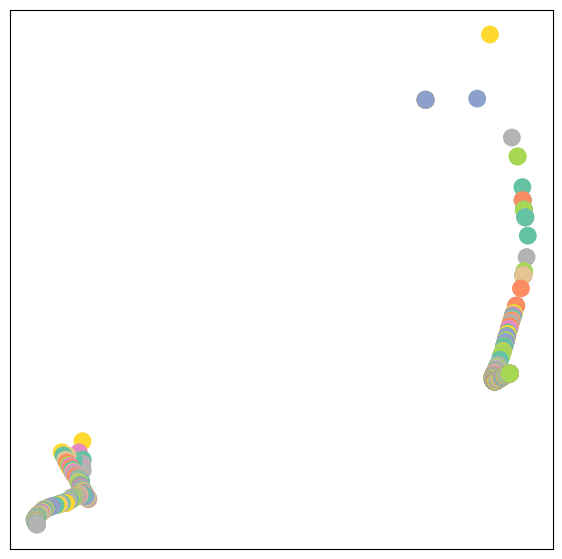

: 

In [ ]:
import matplotlib.pyplot as plt
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)



<IPython.core.display.Javascript object>

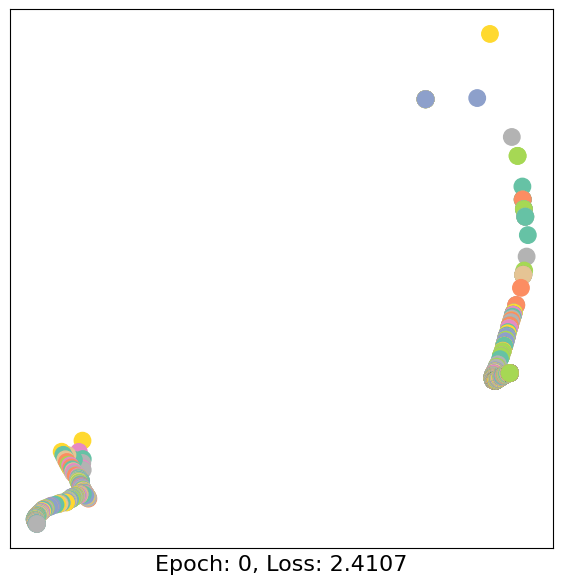

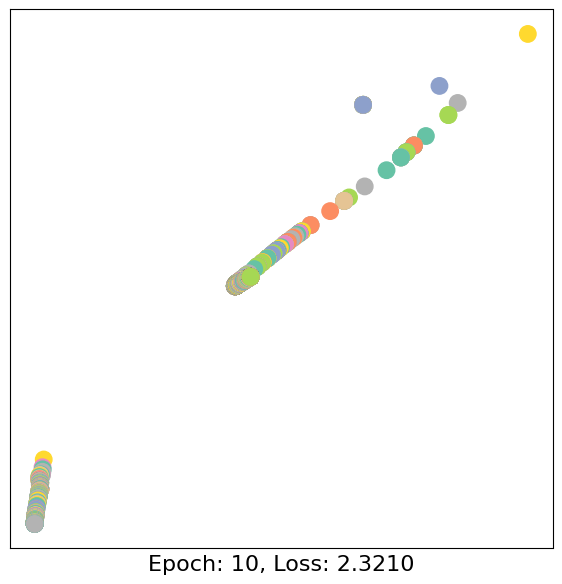

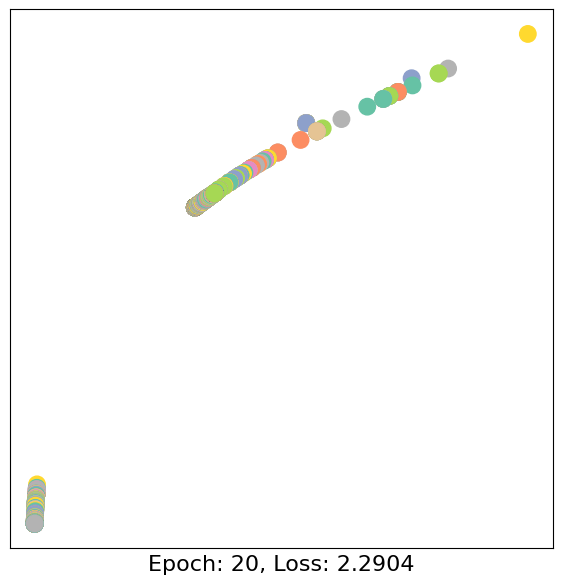

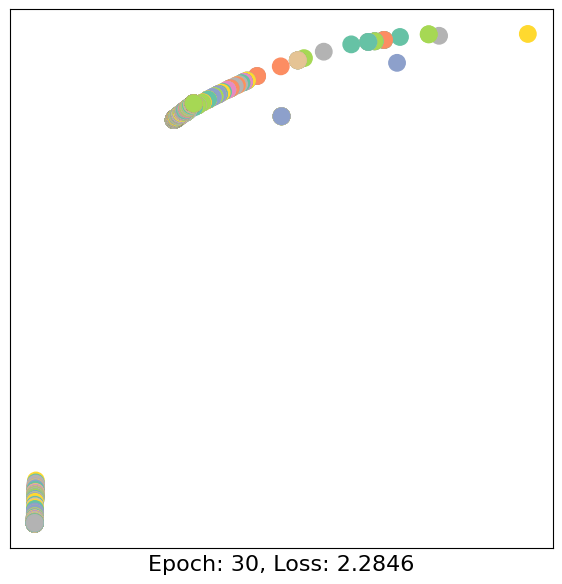

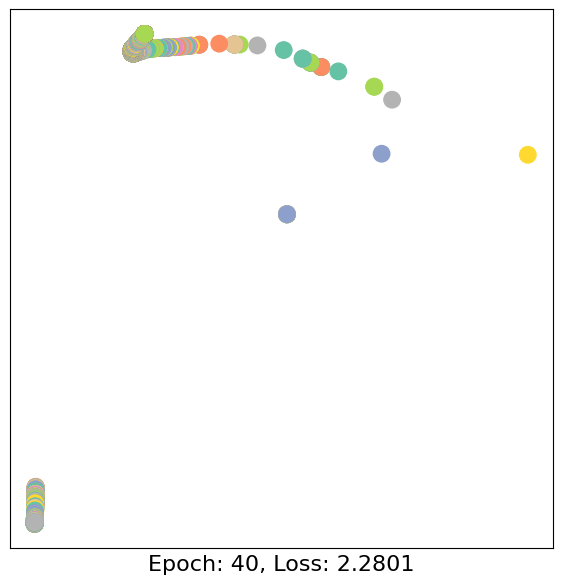

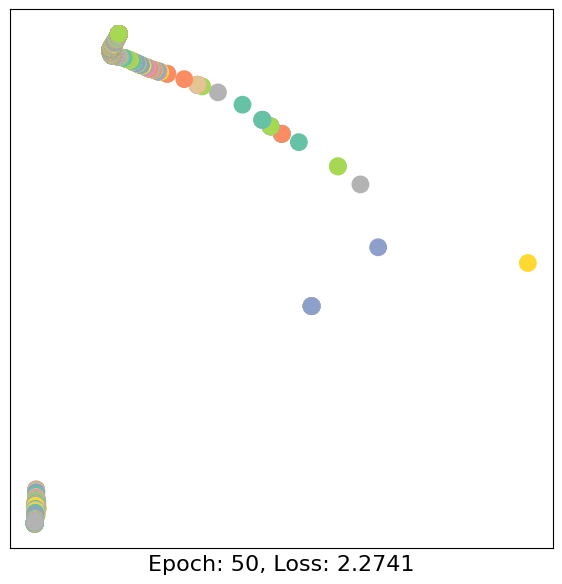

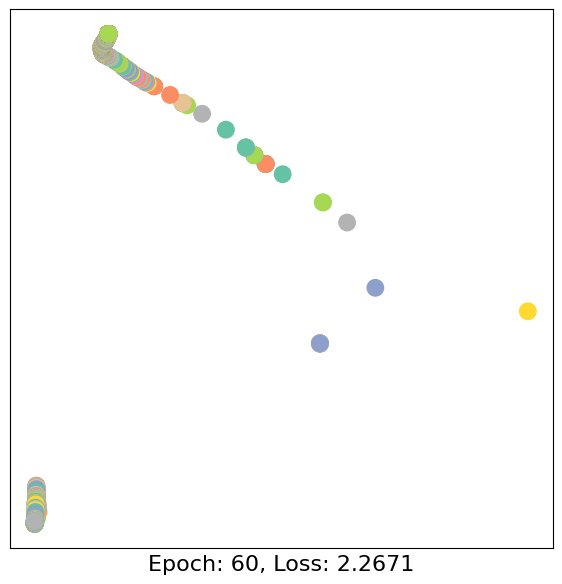

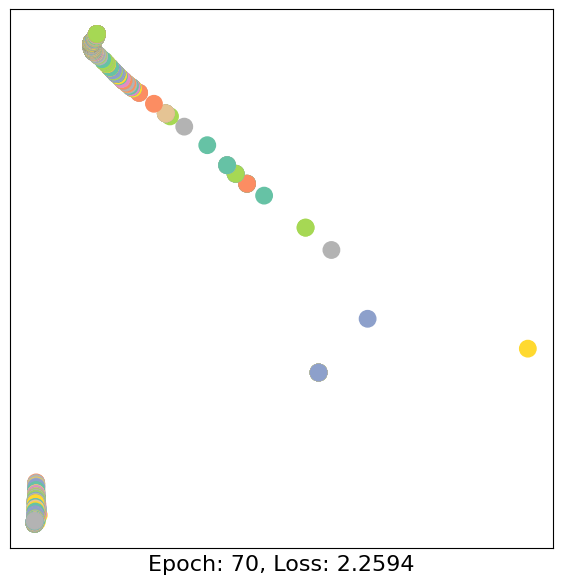

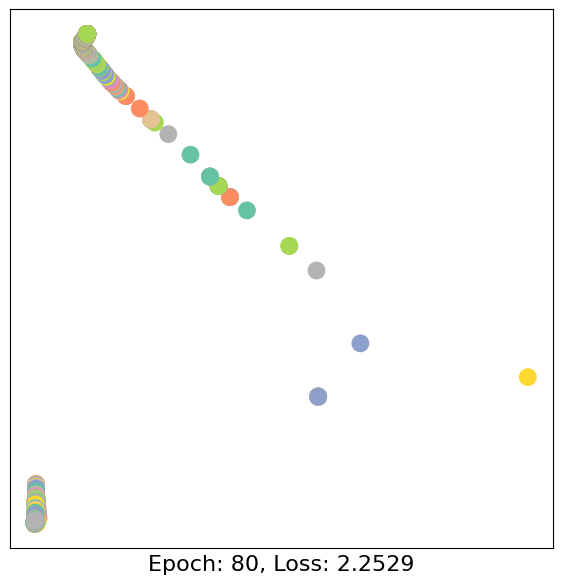

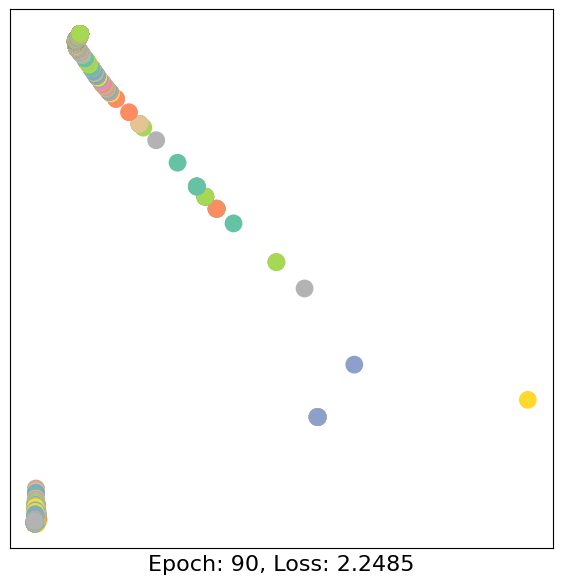

: 

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask].long())  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(100):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [ ]:
with torch.no_grad():
    model.eval()  # Переведите модель в режим оценки (без обучения)
    logits, _ = model(data.x, data.edge_index)

: 

In [ ]:
predicted_labels = logits.argmax(dim=1)


: 

In [ ]:
data.pred_labels = predicted_labels



: 

In [ ]:
data

Data(x=[1355, 2], edge_index=[2, 365560], y=[1355], train_mask=[1355], test_mask=[1355], pred_labels=[1355])

: 

In [ ]:
data.pred_labels

tensor([0, 0, 0,  ..., 9, 9, 9])

: 

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(data.y, data.pred_labels)
print("Accuracy:", accuracy)


Accuracy: 0.10848708487084871


: 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(data.y, data.pred_labels)
print("Confusion Matrix:\n", confusion)


Confusion Matrix:
 [[ 34   0   0   0   0   1   0   0   0 113]
 [ 34   0   0   0   0   0   0   0   0  82]
 [ 20   0   0   0   0   0   0   0   0  95]
 [ 41   0   0   0   0   1   0   0   0 118]
 [ 27   0   0   0   0   0   0   0   0 106]
 [ 30   0   0   0   0   2   0   0   0 122]
 [ 28   0   0   0   0   1   0   0   0 101]
 [ 35   0   0   0   0   0   0   0   0  92]
 [ 45   0   0   0   0   1   0   0   0  92]
 [ 23   0   0   0   0   0   0   0   0 111]]


: 

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(data.y, data.pred_labels)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.11      0.23      0.15       148
         1.0       0.00      0.00      0.00       116
         2.0       0.00      0.00      0.00       115
         3.0       0.00      0.00      0.00       160
         4.0       0.00      0.00      0.00       133
         5.0       0.33      0.01      0.03       154
         6.0       0.00      0.00      0.00       130
         7.0       0.00      0.00      0.00       127
         8.0       0.00      0.00      0.00       138
         9.0       0.11      0.83      0.19       134

    accuracy                           0.11      1355
   macro avg       0.05      0.11      0.04      1355
weighted avg       0.06      0.11      0.04      1355



/Users/mvin/Desktop/masterplanning/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mvin/Desktop/masterplanning/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mvin/Desktop/masterplanning/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

: 